# First (baby) steps
*Rocío Byron, Jan. 2018*

The goal of this notebook is to test out how far one can get with the simplest tools available: basic feature engineering and linear regression modeling. And on the way, learn how to work on Jupyter Notebook.

***
## Inspirations

There are hundreds of kernels on this competition, and I have probably read half of them at some point or another. Two kernels, however, have inspired me the most:

1. [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) by Serigne
2. The ubiquous [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) by Pedro Marcelino

## Outline

1. Preprocessing
    1. Understanding the problem and the data available
    2. Normality and skewness
    3. Missing values
    4. Dummy encoding
    5. Rescaling
2. Regression
    1. Linear regression
    2. L1 regularisation
    3. L2 regularisation
    4. ElasticNet regularisation

In [0]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
%matplotlib inline

# 1. Preprocessing 

The main goal here is to get rid of (very) spurious data points and prepare the dataset for learning. 

This is a very delicate process: go to far, and you will be introducing bias in your data. Go to short, and you will be introducing rubbish in your learning process.

## A. The dataset

In [0]:
## Alterations needed to execute a file downloaded locally on colab CLOUD
import io
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [0]:
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

In [0]:
## Alterations needed to execute a file downloaded locally on colab CLOUD
import io
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [0]:
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

In [35]:
train.ndim

2

In [36]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [37]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [0]:
#train = pd.read_csv('../input/train.csv')  // Replaced with colab CLOUD load
#test = pd.read_csv('../input/test.csv')    // Replaced with colab CLOUD load
testID = test['Id']

data = pd.concat([train.drop('SalePrice', axis=1), test], keys=['train', 'test'])
data.drop(['Id'], axis=1, inplace=True)

In [39]:
data.head(2)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
train 0          60       RL         65.0     8450   Pave   NaN      Reg   
      1          20       RL         80.0     9600   Pave   NaN      Reg   

        LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
train 0         Lvl    AllPub    Inside      ...                 0        0   
      1         Lvl    AllPub       FR2      ...                 0        0   

        PoolQC Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  \
train 0    NaN   NaN         NaN       0       2    2008        WD   
      1    NaN   NaN         NaN       0       5    2007        WD   

         SaleCondition  
train 0         Normal  
      1         Normal  

[2 rows x 79 columns]

In [40]:
data.size

230601

In [41]:
data.shape

(2919, 79)

In [42]:
data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


### Sanity check

Before we go on and process this data, we need to be sure it actually makes sense. There are three "low hanging fruits" in this sense:
- Features that represent years should not go take values larger than 2018
- Areas, distances and prices should not take negative values
- Months should be between 1 and 12

In [0]:
years = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
metrics = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
         '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
         'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

In [44]:
data[years].max()

YearBuilt       2010.0
YearRemodAdd    2010.0
GarageYrBlt     2207.0
YrSold          2010.0
dtype: float64

In [45]:
mask = (data[years] > 2018).any(axis=1) # take any index with a twisted year value
data[mask]

,,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
test,1132,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2007,New,Partial


In [0]:
data.loc[mask, 'GarageYrBlt'] = data[mask]['YearBuilt']

In [47]:
mask = (data[metrics] < 0).any(axis=1)
data[mask]

,,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


In [48]:
mask = ((data['MoSold'] > 12) | (data['MoSold'] < 1))
data[mask]

,,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


### Data types

In terms of data type, there are four big groups:

1. Continuous numerical features: lengths, areas, prices
2. Discrete numerical features: numerical scores, number of bedrooms, years; they support order and arithmetic operations, so they can be treated as numerical
3. Ordinal categorical features: features with qualitative scores (such as 'Excellent' or 'Slightly Irregular'); They support ordering ('Gentle slope' < 'Severe slope') but not arithmetic operations (how much is 'Sever slope' - 'Gentle slope'?)
4. Purely categorical features: a few examples are 'MSSubClass' or 'SaleType'

After some trial and error, I decide to separate numerical (both continuous and discrete) from categorical.

The pros:
- We keep the relationship between discrete numerical features
- We end up with less features, hence less risk of overfitting

The cons: 
- We add some arbitrariness (if a house is an "8" is it really twice as better than a house that scores a 4?)

In [0]:
# Numerical features
num_feats = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
             'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 
             'BsmtQual', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
             'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
             'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
             'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
             'Fireplaces', 'FireplaceQu', 'GarageYrBlt',
             'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
             'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
             'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal',
             'YrSold']    

# We need to convert literal grades to a numerical scale
grades = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
          'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
literal = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
num = [9, 7, 5, 3, 2]
G = dict(zip(literal, num))

data[grades] = data[grades].replace(G)

# Categorical features: everything that is not 'numerical'
cat_feats = data.drop(num_feats, axis=1).columns

In [50]:
cat_feats

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir',
       'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive',
       'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')

## B. Normality and skewness

Many regression models are more comfortable with normally distributed variables (or at least something close to it). 

We will, however, skip the discrete numerical features because:
- The results will be more readable this way
- Most of the discrete numerical features only take a few different values, so hoping for normality is a waste of time

In [0]:
#log transform the target:
price = np.log1p(train['SalePrice'])

#log transform skewed continuous numerical features:
skewed_feats = data.loc['train'][metrics].apply(lambda x: x.skew(skipna=True)) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

data[skewed_feats] = np.log1p(data[skewed_feats])

## C. Missing values

There are two main types of NaN here:
* Missing values: just some of the values that where not recorded (usually a small number of them)
* Missing feature in the house: such as when there is no basement or no garage

In [52]:
data.isnull().sum()[data.isnull().sum() > 0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

### MSZoning, Utilities, Exteriors, Electrical, Functional, Utilities and SaleType

There are not many missing values, so we will just go with the mode of the neighbourhood.

In [0]:
feats = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical', 'Functional',
         'SaleType']
model = data.loc['train'].groupby('Neighborhood')[feats].apply(lambda x: x.mode().iloc[0])

for f in feats:
    data[f].fillna(data['Neighborhood'].map(model[f]), inplace=True)

### Lot frontage

My best guess is that it depends somewhat strongly on the configuration of the lot (inside/corner/cul/2-frontage/3-frontage).

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


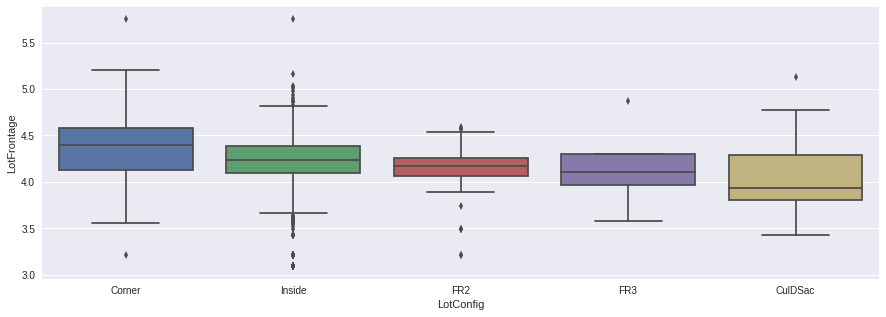

In [54]:
plt.subplots(figsize=(15,5))
boxdata = data.loc['train'].groupby('LotConfig')['LotFrontage'].median().sort_values(ascending=False)
order = boxdata.index
sns.boxplot(x='LotConfig', y='LotFrontage', order=order, data=data.loc['train'])

In [0]:
data['LotFrontage'] = data['LotFrontage'].fillna(data.loc['train', 'LotFrontage'].median())

### KitchenQual

Again, very few missing values. We will substitute in this case with the 'OverallQual' value.

In [0]:
data['KitchenQual'].fillna(data['OverallQual'], inplace=True)

### Basement, garage, fireplaces and other features

We can interpret an NA in all these things as "the house does not have this feature".

In [0]:
bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath',
        'BsmtHalfBath', 
        'TotalBsmtSF']
fire = ['Fireplaces', 'FireplaceQu']
garage = ['GarageQual', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageCars', 
          'GarageArea', 'GarageYrBlt']
masn = ['MasVnrType', 'MasVnrArea']
others = ['Alley', 'Fence', 'PoolQC', 'MiscFeature']

cats = data.columns[data.dtypes == 'object']
nums = list(set(data.columns) - set(cats))

# Be sure the category 'None' is also handled here
data['MasVnrType'].replace({'None': np.nan}, inplace=True)

data[cats] = data[cats].fillna('0')
data[nums] = data[nums].fillna(0)

In [58]:
data.isnull().sum().sum()

0

### Adjusting the type of variable

First, there are a few features that are not represented with the right type of variable:

- 'MSSubClass': represented as an integer, when it is just a category label (we will use 'object' for now)
- 'MoSold': represented as an integer, a month is just a category label out of 12 possibilities (we will use 'object' for now)
- 'BsmtFullBath', 'BsmtHalfBath': these two represent integers and not floats (or I at least I do not know what a third of half bathroom is)
- years: a year, in the context of this dataset, is an integer, and not a float
- 'GarageCars': represented as a float, it is an actual integer (nobody wants to have 0.5 car at home)

In [0]:
data['MSSubClass'] = data['MSSubClass'].astype('object', copy=False)
data['MoSold'] = data['MoSold'].astype('object', copy=False)
data['BsmtFullBath'] = data['BsmtFullBath'].astype('int64', copy=False)
data['BsmtHalfBath'] = data['BsmtHalfBath'].astype('int64', copy=False)
data['GarageCars'] = data['GarageCars'].astype('int64', copy=False)
data[years] = data[years].astype('int64', copy=False)

### Categorical data with few samples per bin

Some categories of the categorical features are so unrrepresented in the dataset that drawing conclusions from them would lead to a noisy result. Instead, we will group those in one single category.

In [0]:
categorical_data = pd.concat((data.loc['train'][cat_feats], price), axis=1)

In [0]:
low = 0.05 * data.loc['train'].shape[0] # at least 5% of the dataset should have this value

for feat in cat_feats:        
    # we will group the categories based on the average sale price
    order = ((categorical_data.groupby(feat).mean()).sort_values(by='SalePrice', 
                                                      ascending=False).index.values.tolist())
    for i in range(0, len(order)):
        N = (categorical_data[categorical_data[feat] == order[i]]
             .count().max())
        j = i
        while (N < low) & (N != 0):
            j += 1

            if (j > len(order) - 1):
                # if reached the end of list, go back to last
                # useful category of the 'order' list
                j = i - 1
                break
            else: 
                N += (categorical_data[categorical_data[feat] == order[j]]
                      .count().max())
        if j < i:
            lim = len(order)
        else:
            lim = j

        for k in range(i, lim):
            categorical_data.replace({feat: {order[k]: order[j]}},
                                 inplace=True)
            data.replace({feat: {order[k]: order[j]}},
                                     inplace=True)            
    uniD = data[feat].unique()
    order = categorical_data[feat].unique()

    for i in uniD:
        if i not in order:
            ind = np.argsort(order - i)[0]
            data.replace({feat: {i: order[ind]}}, inplace=True)

In [62]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## D. Dummy encoding

### Categorical data as categories

First, we need to turn those features with two categories into 0-1 encoding (the get_dummies method would convert them into two separate features otherwise, feat_0 and feat_1).

In [63]:
# Remove columns with just one category
for feat in categorical_data.columns[:-1]:    
    uni = categorical_data.groupby(feat).mean().sort_values(by='SalePrice').index
    if (len(uni) < 2):
            data.drop(feat, axis=1, inplace=True)
    elif len(uni) < 3:
        print("{}: {}".format(feat, uni))
        data[feat].replace({uni[0]: 0, uni[1]: 1}, inplace=True)
        data[feat] = data[feat].astype('int8')
    else:
        data[feat] = data[feat].astype('category')
        

MSZoning: Index(['RM', 'RL'], dtype='object', name='MSZoning')
Alley: Index(['Grvl', '0'], dtype='object', name='Alley')
LotShape: Index(['Reg', 'IR1'], dtype='object', name='LotShape')
LandContour: Index(['Lvl', 'Low'], dtype='object', name='LandContour')
LandSlope: Index(['Gtl', 'Mod'], dtype='object', name='LandSlope')
Condition1: Index(['Feedr', 'Norm'], dtype='object', name='Condition1')
RoofStyle: Index(['Gable', 'Hip'], dtype='object', name='RoofStyle')
BsmtFinType2: Index(['Rec', 'Unf'], dtype='object', name='BsmtFinType2')
CentralAir: Index(['N', 'Y'], dtype='object', name='CentralAir')
Electrical: Index(['FuseA', 'SBrkr'], dtype='object', name='Electrical')
Functional: Index(['Min2', 'Typ'], dtype='object', name='Functional')
PavedDrive: Index(['N', 'Y'], dtype='object', name='PavedDrive')
Fence: Index(['MnPrv', '0'], dtype='object', name='Fence')
SaleType: Index(['WD', 'New'], dtype='object', name='SaleType')


In [0]:
finaldata = pd.get_dummies(data)

The variables that express a "I don't have this" feature should not treat the '0' as a normal category. Instead, it would be cleaner (and less overfitting) to encode the zero in the other possible options.

In [0]:
black_list = bsmt + fire + garage + masn + others
for feat in finaldata.columns:
    if ('_0' in feat) and (feat.split("_")[0] in black_list):
        finaldata.drop(feat, axis=1, inplace=True)

In [66]:
finaldata.shape

(2919, 131)

## E. Rescaling

I will just separate the data and normalise it to make the regressors run smoother. As @Gennadi mentioned in the comments, I have to be careful not to leak any data from the test set into my training set. 

That is: I can only use the mean and standard dev of my train set to normalise.

In [0]:
# Training/testing sets
X_test = finaldata.loc['test']
X_train = finaldata.loc['train']

y_train = price

In [0]:
m = X_train.mean()
std = X_train.std()

X_train = (X_train - m) / std
X_test = (X_test - m) / std

# 2. Regression


## A. Linear regression (without regularisation)

In [80]:
# Create linear regression object
LR = LinearRegression()

# Train the model using the training sets
LR.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### Top influencers

In [81]:
maxcoef = np.argsort(-np.abs(LR.coef_))
coef = LR.coef_[maxcoef]
for i in range(0, 5):
    print("{:.<025} {:< 010.4e}".format(finaldata.columns[maxcoef[i]], coef[i]))

Foundation_PConc.........  1.0180e+10
Foundation_CBlock........  1.0173e+10
Foundation_BrkTil........  6.5731e+09
BldgType_1Fam............  5.5431e+09
BsmtFinType1_Unf.........  4.7866e+09


The coefficients indicate that this model is <u>very</u> overfitted. We can blame this on the correlation of several of the features:

1. Dummy features are by definition correlated (i.e. if LotShape_Reg = 1, we can be certain that LotShape_IR1 = 0 for that house)
2. There might be other correlated features: 'GrLivArea' is probably very close to the sum of the first and second floor areas.

## B. Linear regression, L1 regularisation

In [71]:
# Create linear regression object
Ls = LassoCV()

# Train the model using the training sets
Ls.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

### Top influencers

In [72]:
maxcoef = np.argsort(-np.abs(Ls.coef_))
coef = Ls.coef_[maxcoef]
for i in range(0, 5):
    print("{:.<025} {:< 010.4e}".format(finaldata.columns[maxcoef[i]], coef[i]))

GrLivArea................  1.1757e-01
OverallQual..............  8.1300e-02
OverallCond..............  4.0020e-02
GarageCars...............  3.7800e-02
YearBuilt................  3.4879e-02


This looks a lot more reasonable. When one thinks about the price of a house, lot area and living area are usually the first guess.

## C. Linear regression, L2 regularisation

In [73]:
# Create linear regression object
Rr = RidgeCV()

# Train the model using the training sets
Rr.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

### Top influencers

In [74]:
maxcoef = np.argsort(-np.abs(Rr.coef_))
coef = Rr.coef_[maxcoef]
for i in range(0, 5):
    print("{:.<025} {:< 010.4e}".format(finaldata.columns[maxcoef[i]], coef[i]))

GrLivArea................  1.2397e-01
OverallQual..............  7.1496e-02
OverallCond..............  4.4677e-02
GarageCars...............  4.0283e-02
GarageYrBlt.............. -3.4590e-02


This is also very consistent with the L1 regularisation.

## D. Linear regression, elastic net

Okay, so one last attempt is to linearly combine Lasso and Ridge regularisations together (what they fancily call elastic net). The advantage of the elastic net is that if two features are correlated, it will retain both instead of just one (remember that in L1 regularisation, most of the features are set to parameter 0). 

In [75]:
# Create linear regression object
EN = ElasticNetCV(l1_ratio=np.linspace(0.1, 1.0, 5)) # we are essentially smashing most of the Rr model here

# Train the model using the training sets
train_EN = EN.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


### Top influencers

In [76]:
maxcoef = np.argsort(-np.abs(EN.coef_))
coef = EN.coef_[maxcoef]
for i in range(0, 5):
    print("{:.<025} {:< 010.4e}".format(finaldata.columns[maxcoef[i]], coef[i]))

GrLivArea................  1.1757e-01
OverallQual..............  8.1300e-02
OverallCond..............  4.0020e-02
GarageCars...............  3.7800e-02
YearBuilt................  3.4879e-02


## Comparison

In [77]:
model = [Ls, Rr, EN]
M = len(model)
CV = 5
score = np.empty((M, CV))
for i in range(0, M):
    score[i, :] = cross_val_score(model[i], X_train, y_train, cv=CV)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The defaul

In [78]:
print(score.mean(axis=1))

[0.90032598 0.89351064 0.90008311]


In [0]:
submit = pd.DataFrame({'Id': testID, 'SalePrice': np.exp(EN.predict(X_test))})
submit.to_csv('submission.csv', index=False)

A few conclusions from here:

- Linear regression, without regularisation, cannot fit this data "as-is". I believe it is because of the strong correlation between some of the variables with each other
- Lasso and Ridge regression work both fairly well. The elastic net does not improve the performance that much

### Future improvements

- Feature engineering: in general, it is not a good idea to feed correlated features to a linear regression model. A way forward could be some deeper analysis of the variables
- These are the simplest supervised learning models out there. My next try will probably be tree-based solutions, which tend to do better in this kind of datasets

And, that's it. If you read this and have some ideas for improvement, please let me know!